# 4 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Pre-Processing and Training Data](#4_Pre-Processing_and_Training_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Load Data](#4.4_Load_Data)
  * [4.5 Train/Test Split](#4.5_Train/Test_Split)
  * [4.6 Initial Not-Even-A-Model](#4.6_Initial_Not-Even-A-Model)
    * [4.6.1 Baseline model ](#4.6.1_Baseline_model)
      * [4.6.1.1 Metrics](#4.6.1.1_metrics)
        * [4.6.1.1.1 Confusion matrix](#4.6.1.1.1_confusion_matrix)
        * [4.6.1.1.2 Accuracy score, Precision score, Recall score, and F1 score](#4.6.1.1.2_accuracy_score_Precision_score_Recall_score_F1_score)
        * [4.6.1.1.3 ROC and AUC score](#4.6.1.1.3_ROC_and_AUC_score)
  * [4.7 Initial Models](#4.7_Initial_Models)
    * [4.7.1 Logistic Regression](#4.7.1_Logistic_Regression)
      * [4.7.1.1 Implimenting the model](#4.7.1.1_Implimenting_model)
      * [4.7.1.2 Assess performance](#4.7.1.2_Assess_performance)
      * [4.7.1.3 Refining the model selecting a different number of features](#4.7.1.3_Refining_The_Model_selecting_a_different_number_of_features)
    * [4.7.2 Support Vector Machines (SVM)](#4.9.1_Support_Vector_Machines_(SVM)
      * [4.7.2.1 Implimenting the model](#4.7.2.1_Implimenting_model)
      * [4.7.2.2 Assess performance](#4.7.2.2_Assess_performance)
      * [4.7.2.3 Refining the model selecting a different number of features](#4.7.2.3_Refining_The_Model_selecting_a_different_number_of_features)
    * [4.7.3 k-nearest neighbors(KNN)](#4.7.3_k_nearest_neighbors(KNN))
      * [4.7.3.1 Implimenting the model](#4.7.3.1_Implimenting_model)
      * [4.7.3.2 Assess performance](#4.7.3.2_Assess_performance)
      * [4.7.3.3 Refining the model selecting a different number of features](#4.7.3.3_Refining_The_Model_selecting_a_different_number_of_features)
    * [4.7.4 Random Forest](#4.7.4_Random_Forest_Model)
      * [4.7.4.1 Implimenting the model](#4.7.4.1_Implimenting_model)
      * [4.7.4.2 Assess performance](#4.7.4.2_Assess_performance)
      * [4.7.4.3 Refining the model selecting a different number of features](#4.7.4.3_Refining_The_Model_selecting_a_different_number_of_features)  
    * [4.7.5 XG Boost Classifier](#4.7.5_XG_Boost_Classifier)
      * [4.7.5.1 Implimenting the model](#4.7.5.1_Implimenting_model)
      * [4.7.5.2 Assess performance](#4.7.5.2_Assess_performance)
      * [4.7.5.3 Refining the model selecting a different number of features](#4.7.5.3_Refining_The_Model_selecting_a_different_number_of_features)  
    * [4.7.6 LightGBM](#4.7.6_LightGBM_Classifier)
      * [4.7.6.1 Implimenting the model](#4.7.6.1_Implimenting_model)
      * [4.7.6.2 Assess performance](#4.7.6.2_Assess_performance)
      * [4.7.6.3 Refining the model selecting a different number of features](#4.7.6.3_Refining_The_Model_selecting_a_different_number_of_features)  
    * [4.7.7 Define a new pipeline to select a different number of features](#4.9.4_Define_a_new_pipeline_to_select_a_different_number_of_features)
      * [4.7.7.1 Implimenting the model](#4.7.1.1_Implimenting_model)
      * [4.7.7.2 Assess performance](#4.7.1.2_Assess_performance)
      * [4.7.7.3 Refining the model selecting a different number of features](#4.7.1.3_Refining_The_Model_selecting_a_different_number_of_features)  
    * [4.7.8 Define a new pipeline to select a different number of features](#4.9.4_Define_a_new_pipeline_to_select_a_different_number_of_features)
      * [4.7.8.1 Implimenting the model](#4.7.1.1_Implimenting_model)
      * [4.7.8.2 Assess performance](#4.7.1.2_Assess_performance)
      * [4.7.8.3 Refining the model selecting a different number of features](#4.7.1.3_Refining_The_Model_selecting_a_different_number_of_features)          

    
  
  * [4.8 Final Model Selection](#4.8_Final_Model_Selection)
    * [4.8.1 LightGBM](#4.8.1_LightGBM)
    * [4.8.2 Conclusion](#4.8.2_Conclusion)
  * [4.9 Data quantity assessment](#4.12_Data_quantity_assessment)
  * [4.10 Save best model object from pipeline](#4.13_Save_best_model_object_from_pipeline)
  * [4.14 Summary](#4.14_Summary)


## 4.2 Introduction<a id='4.2_Introduction'></a>

In preceding notebooks, performed preliminary assessments of data quality and refined the question to be answered. The detecting the normal ecgs was the primary aim. 

In this notebook we'll start to build machine learning models. The first model is a baseline performance comparitor for any subsequent model. Then, models are built and the process of efficiently and robustly creating and assessing models against it will be performed. 

## 4.3 Imports<a id='4.3_Imports'></a>

In [25]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier




from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve

from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression, SelectFromModel

import datetime

from library.sb_utils import save_file

## 4.4 Load Data<a id='4.4_Load_Data'></a>

In [2]:
ecg_data = pd.read_csv('../data/ecg_data_step3_features.csv')
ecg_data.head().T

,0,1,2,3,4
t0,-0.112522,-1.100878,-0.567088,0.490473,0.800232
t1,-2.827204,-3.996840,-2.593450,-1.914407,-0.874252
t2,-3.773897,-4.285843,-3.874230,-3.616364,-2.384761
t3,-4.349751,-4.506579,-4.584095,-4.318823,-3.973292
t4,-4.376041,-4.022377,-4.187449,-4.268016,-4.338224
...,...,...,...,...,...
t136,0.228077,0.476333,-0.532197,0.990133,0.960304
t137,0.123431,0.773820,0.321097,1.086798,0.971020
t138,0.925286,1.119621,0.904227,1.403011,1.614392
t139,0.193137,-1.436250,-0.421797,-0.383564,1.421456


## 4.5 Train/Test Split<a id='4.5_Train/Test_Split'></a>

In [3]:
X_train, X_test, y_train, y_test = train_test_split(ecg_data.drop(columns='Target'), 
                                                    ecg_data.Target, test_size=0.3, 
                                                    random_state=47)

In [4]:
X_train.shape, y_train.shape, X_test.shape,  y_test.shape

((3498, 140), (3498,), (1500, 140), (1500,))

## 4.6 Initial Not-Even-A-Model<a id='4.6_Initial_Not-Even-A-Model'></a>

To be able to truly understand and then improve our model’s performance, we first need to establish a baseline for the data that we have. 

### 4.6.1 Baseline model <a id='4.6.1_Baseline_model '></a>

`sklearn`'s `DummyClassifier` easily does this:

In [29]:
#Fit the dummy classifier on the training data
dummy_clf = DummyClassifier(random_state=42)
dummy_clf.fit(X_train, y_train)
y_te_pred = dummy_clf.predict(X_test)
y_tr_pred = dummy_clf.predict(X_train)


c:\Users\armag\Anaconda3\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


#### 4.6.1.1 Metrics<a id='4.6.1.1_metrics'></a>

In [30]:
print('Accuracy of dummy classifier model on train and test:',dummy_clf.score(X_train, y_train), dummy_clf.score(X_test, y_test))

Accuracy of dummy classifier model on train and test: 0.5105774728416238 0.502


##### 4.6.1.1.1 Confusion matrix <a id='4.6.1.1.1_confusion_matrix'></a>

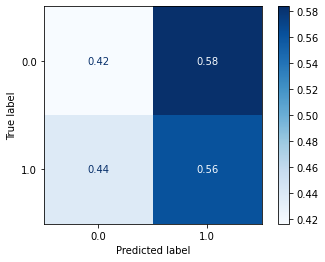

In [31]:
plot_confusion_matrix(estimator=dummy_clf, X=X_test, y_true=y_test, normalize='true', cmap='Blues')

here we can see that the model correctly predicted abnormal ecg (TNs, upper left quadrant) 42% of the time, and the predictions for normal ecgs (TPs, bottom right quadrant) is at 56%.
Let’s take a look at the value_counts of the data to see whether we can figure out why this is the case.

In [32]:
y_train.value_counts(normalize=True)

1.0    0.582047
0.0    0.417953
Name: Target, dtype: float64

There are slightly more normal ecgs in the dataset, so the dummy classifier is predicting more normal ecgs compared to abnormal ecgs.

##### 4.6.1.1.2 Accuracy score, Precision score, Recall score, and F1 score <a id='4.6.1.1.2_accuracy_score_Precision_score_Recall_score_F1_score'></a>

In [33]:
print('Dummy Classifier Model , strategy: prior\n  Accuracy {0:.2f}, Precision {0:.2f}, Recall {0:.2f}, F1-score {0:.2f}'\
    .format(accuracy_score(y_test, y_te_pred), precision_score(y_test, y_te_pred), recall_score(y_test, y_te_pred), f1_score(y_test, y_te_pred)))


Dummy Classifier Model , strategy: prior
  Accuracy 0.50, Precision 0.50, Recall 0.50, F1-score 0.50


In [34]:
print(' Accuracy score in train and test dataset:  ',  accuracy_score(y_train, y_tr_pred),' , ', accuracy_score(y_test, y_te_pred))
print(' precision score in train and test dataset: ',  precision_score(y_train, y_tr_pred),' , ', precision_score(y_test, y_te_pred))
print(' Recall score in train and test dataset:    ',  recall_score(y_train, y_tr_pred),' , ', recall_score(y_test, y_te_pred))
print(' F1 score in train and test dataset:        ',  f1_score(y_train, y_tr_pred),' , ', f1_score(y_test, y_te_pred))


 Accuracy score in train and test dataset:   0.5105774728416238  ,  0.502
 precision score in train and test dataset:  0.581081081081081  ,  0.5794392523364486
 Recall score in train and test dataset:     0.5702357563850687  ,  0.5617214043035108
 F1 score in train and test dataset:         0.5756073376301437  ,  0.5704427832087406


##### 4.6.1.1.3 ROC and AUC score<a id='4.6.1.1.3_ROC_and_AUC_score'></a>

In [35]:
def plot_ROC(model,X, y, title_method ):
    logit_roc_auc = roc_auc_score(y, model.predict(X))
    fpr, tpr, thresholds = roc_curve(y, model.predict_proba(X)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='{} (area = {:2.2%})'.format(title_method,logit_roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

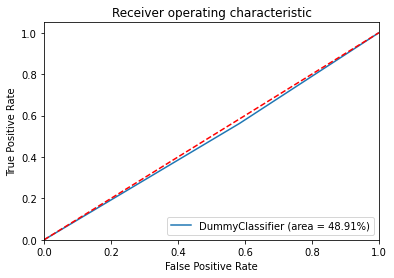

In [36]:
plot_ROC(dummy_clf, X_test, y_test,'DummyClassifier')

## 4.7 Initial Models<a id='4.7_Initial_Models'></a>

### 4.7.1 Logistic Regression<a id='4.7.1_Logistic_Regression'></a>

#### 4.7.1.1 Implimenting the model<a id='4.7.1.1_Implimenting_model'></a>

In [37]:
pipe1 = make_pipeline(
    StandardScaler(), 
    LogisticRegression(random_state=42, solver="liblinear")
)
pipe1.fit(X_train, y_train)
y_tr_pred = pipe1.predict(X_train)
y_te_pred = pipe1.predict(X_test)

#### 4.7.1.2  Assess performance<a id='4.7.1.2_Assess_performance'></a>

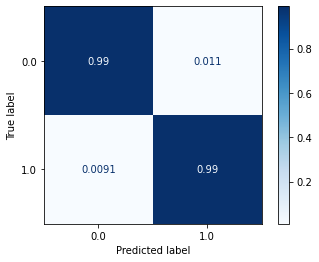

In [38]:
plot_confusion_matrix(estimator=pipe1, X=X_test, y_true=y_test, normalize='true', cmap='Blues')

In [39]:
def print_performance_results(y_train, y_tr_pred,y_test, y_te_pred):
    print(' Accuracy score in train and test dataset:  ',  accuracy_score(y_train, y_tr_pred),' , ', accuracy_score(y_test, y_te_pred))
    print(' precision score in train and test dataset: ',  precision_score(y_train, y_tr_pred),' , ', precision_score(y_test, y_te_pred))
    print(' Recall score in train and test dataset:    ',  recall_score(y_train, y_tr_pred),' , ', recall_score(y_test, y_te_pred))
    print(' F1 score in train and test dataset:        ',  f1_score(y_train, y_tr_pred),' , ', f1_score(y_test, y_te_pred))    

print_performance_results(y_train, y_tr_pred,y_test, y_te_pred)    

 Accuracy score in train and test dataset:   0.9942824471126358  ,  0.99
 precision score in train and test dataset:  0.9936336924583742  ,  0.9920634920634921
 Recall score in train and test dataset:     0.9965618860510805  ,  0.9909399773499433
 F1 score in train and test dataset:         0.9950956351152526  ,  0.991501416430595


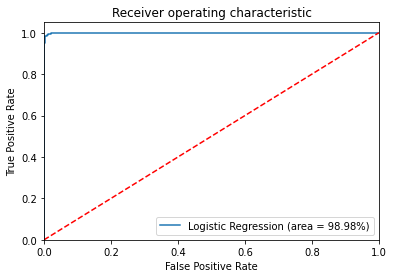

In [40]:
plot_ROC(pipe1, X_test, y_test,'Logistic Regression')

#### 4.7.1.3 Refining the model selecting a different number of features<a id='4.7.1.3_Refining_The_Model_selecting_a_different_number_of_features'></a>

In [41]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

pipe1_2 = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=40),
    LogisticRegression(solver="liblinear")
)
lr_grid_cv = GridSearchCV(pipe1_2, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
best_k = lr_grid_cv.best_params_['selectkbest__k']
print('Best k: ',best_k)


Best k:  90


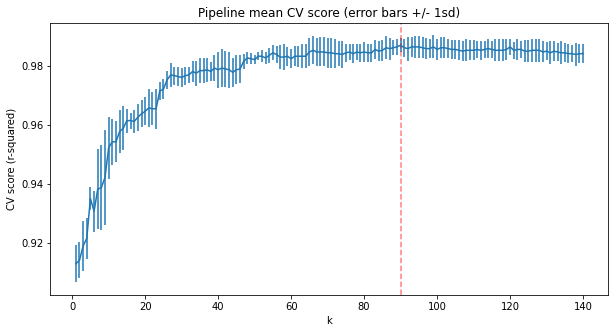

In [42]:
def plot_pipeline_mean_CV_score(cv_k, best_k, score_mean, score_std ): 
    plt.subplots(figsize=(10, 5))
    plt.errorbar(cv_k, score_mean, yerr=score_std)
    plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
    plt.xlabel('k')
    plt.ylabel('CV score (r-squared)')
    plt.title('Pipeline mean CV score (error bars +/- 1sd)');

plot_pipeline_mean_CV_score(cv_k, best_k, score_mean, score_std )

The above suggests a good value for k is 90. There was an initial rapid increase with k, followed by a slow decline. 

### 4.7.2 Support Vector Machines (SVM)<a id='4.9.1_Support_Vector_Machines_(SVM)'></a>

#### 4.7.2.1 Implimenting the model<a id='4.7.2.1_Implimenting_model'></a>

In [43]:
pipe2 = make_pipeline(
    StandardScaler(),
    SVC(kernel="linear",probability=True)
)
pipe2.fit(X_train, y_train)
y_tr_pred = pipe2.predict(X_train)
y_te_pred = pipe2.predict(X_test)

#### 4.7.2.2 Assess performance<a id='4.7.2.2_Assess_performance'></a>

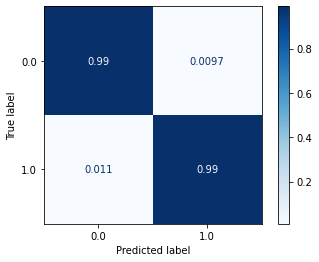

In [44]:
plot_confusion_matrix(estimator=pipe2, X=X_test, y_true=y_test, normalize='true', cmap='Blues')

In [45]:
print_performance_results(y_train, y_tr_pred,y_test, y_te_pred)

 Accuracy score in train and test dataset:   0.9957118353344768  ,  0.9893333333333333
 precision score in train and test dataset:  0.9960726558664703  ,  0.9931740614334471
 Recall score in train and test dataset:     0.9965618860510805  ,  0.9886749716874292
 F1 score in train and test dataset:         0.9963172109010557  ,  0.9909194097616345


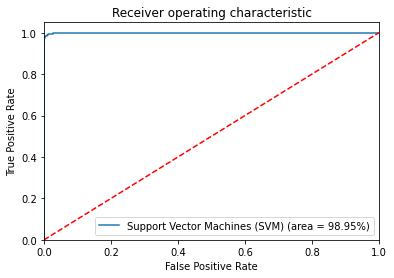

In [46]:
plot_ROC(pipe2, X_test, y_test,'Support Vector Machines (SVM)')

#### 4.7.2.3 Refining the model selecting a different number of features<a id='4.7.2.3_Refining_The_Model_selecting_a_different_number_of_features'></a>

In [47]:
k = [k+1 for k in range(len(X_train.columns))]
# grid_params = {'selectkbest__k': k, 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'svc__kernel': ['rbf','linear']}
grid_params = { 'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'svc__kernel': ['rbf','linear']}

pipe2_2 = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=40),
    SVC(probability=True)
    
)
# svm.LinearSVC(penalty='l2')

lr_grid_cv = GridSearchCV(pipe2_2, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
best_k = lr_grid_cv.best_params_['selectkbest__k']
print('Best k: ',best_k)


KeyError: 'param_selectkbest__k'

In [ ]:
plot_pipeline_mean_CV_score(cv_k, best_k, score_mean, score_std )

### 4.7.3 k-nearest neighbors(KNN)<a id='4.7.3_k_nearest_neighbors(KNN)'></a>

#### 4.7.3.1 Implimenting the model<a id='4.7.3.1_Implimenting_model'></a>

In [28]:
pipe3 = make_pipeline(
    StandardScaler(), 
    KNeighborsClassifier()
)
pipe3.fit(X_train, y_train)
y_tr_pred = pipe3.predict(X_train)
y_te_pred = pipe3.predict(X_test)

#### 4.7.3.2 Assess performance<a id='4.7.3.2_Assess_performance'></a>

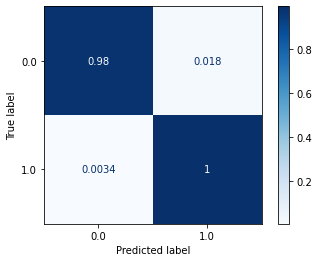

In [29]:
plot_confusion_matrix(estimator=pipe3, X=X_test, y_true=y_test, normalize='true', cmap='Blues')

In [30]:
print_performance_results(y_train, y_tr_pred,y_test, y_te_pred)

 Accuracy score in train and test dataset:   0.9888507718696398  ,  0.9906666666666667
 precision score in train and test dataset:  0.9844735565259582  ,  0.9876543209876543
 Recall score in train and test dataset:     0.9965618860510805  ,  0.9966024915062288
 F1 score in train and test dataset:         0.99048083963876  ,  0.992108229988726


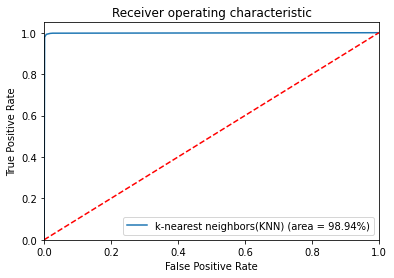

In [32]:
plot_ROC(pipe3, X_test, y_test,'k-nearest neighbors(KNN)')

#### 4.7.3.3 Refining the model selecting a different number of features<a id='4.7.3.3_Refining_The_Model_selecting_a_different_number_of_features'></a>

In [36]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k,'kneighborsclassifier__weights': ['uniform','distance'],'kneighborsclassifier__n_neighbors': [2]}

pipe3_1 = make_pipeline(
    StandardScaler(),
    SelectKBest(),
    KNeighborsClassifier()
)

lr_grid_cv = GridSearchCV(pipe3_1, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
best_k = lr_grid_cv.best_params_['selectkbest__k']
print('Best k: ',best_k)


Best k:  59


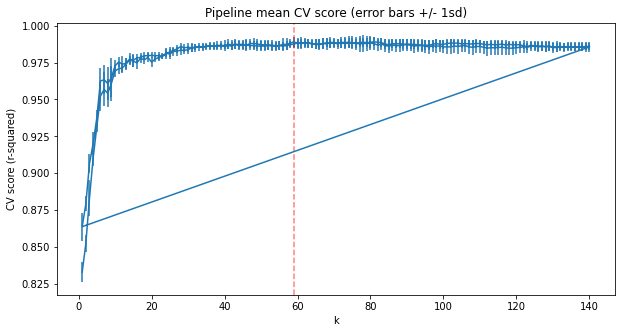

In [37]:
plot_pipeline_mean_CV_score(cv_k, best_k, score_mean, score_std )

The above suggests a good value for k is 59. There was an initial rapid increase with k, followed by a slow decline. 

### 4.7.4 Random Forest Model<a id='4.7.4_Random_Forest_Model'></a>

#### 4.7.4.1 Implimenting the model<a id='4.7.4.1_Implimenting_model'></a>

In [40]:
pipe4 = make_pipeline(
    StandardScaler(), 
    RandomForestClassifier()
)
pipe4.fit(X_train, y_train)
y_tr_pred = pipe4.predict(X_train)
y_te_pred = pipe4.predict(X_test)

#### 4.7.4.2 Assess performance<a id='4.7.4.2_Assess_performance'></a>

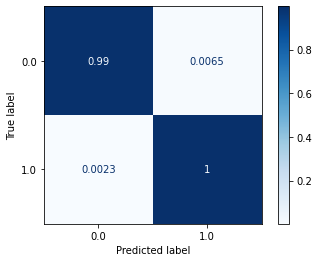

In [41]:
plot_confusion_matrix(estimator=pipe4, X=X_test, y_true=y_test, normalize='true', cmap='Blues')

In [42]:
print_performance_results(y_train, y_tr_pred,y_test, y_te_pred)

 Accuracy score in train and test dataset:   1.0  ,  0.996
 precision score in train and test dataset:  1.0  ,  0.9954802259887006
 Recall score in train and test dataset:     1.0  ,  0.9977349943374858
 F1 score in train and test dataset:         1.0  ,  0.9966063348416289


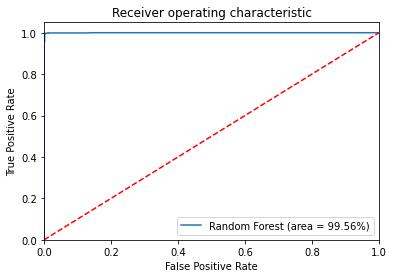

In [48]:
plot_ROC(pipe4, X_test, y_test,'Random Forest')

#### 4.7.4.3 Refining the model selecting a different number of features<a id='4.7.4.3_Refining_The_Model_selecting_a_different_number_of_features'></a>

### 4.7.5 XG Boost Classifier<a id='4.7.5_XG_Boost_Classifier'></a>

#### 4.7.5.1 Implimenting the model<a id='4.7.5.1_Implimenting_model'></a>

In [ ]:
pipe5 = make_pipeline(
    StandardScaler(), 
    XGBClassifier(random_state=42)
)
pipe5.fit(X_train, y_train)
y_tr_pred = pipe5.predict(X_train)
y_te_pred = pipe5.predict(X_test)

In [ ]:
pipe5.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'xgbclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'xgbclassifier__objective', 'xgbclassifier__base_score', 'xgbclassifier__booster', 'xgbclassifier__colsample_bylevel', 'xgbclassifier__colsample_bynode', 'xgbclassifier__colsample_bytree', 'xgbclassifier__gamma', 'xgbclassifier__gpu_id', 'xgbclassifier__importance_type', 'xgbclassifier__interaction_constraints', 'xgbclassifier__learning_rate', 'xgbclassifier__max_delta_step', 'xgbclassifier__max_depth', 'xgbclassifier__min_child_weight', 'xgbclassifier__missing', 'xgbclassifier__monotone_constraints', 'xgbclassifier__n_estimators', 'xgbclassifier__n_jobs', 'xgbclassifier__num_parallel_tree', 'xgbclassifier__random_state', 'xgbclassifier__reg_alpha', 'xgbclassifier__reg_lambda', 'xgbclassifier__scale_pos_weight', 'xgbclassifier__subsample', 'xgbclassifier__tree_method', 'xgbclassifier__validate_parameters', 'xgbclassifier__verbosity

#### 4.7.5.2  Assess performance<a id='4.7.5.2_Assess_performance'></a>

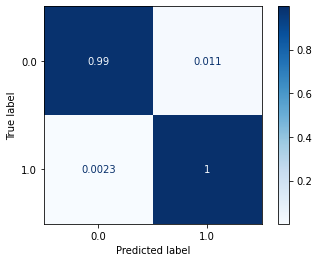

In [ ]:
plot_confusion_matrix(estimator=pipe5, X=X_test, y_true=y_test, normalize='true', cmap='Blues')

In [ ]:
print_performance_results(y_train, y_tr_pred,y_test, y_te_pred)    

 Accuracy score in train and test dataset:   1.0  ,  0.994
 precision score in train and test dataset:  1.0  ,  0.9921171171171171
 Recall score in train and test dataset:     1.0  ,  0.9977349943374858
 F1 score in train and test dataset:         1.0  ,  0.994918125352908


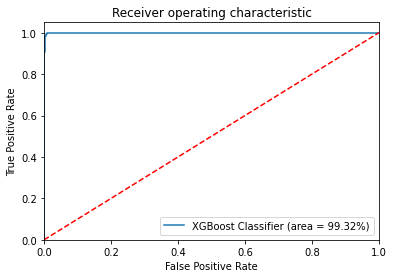

In [ ]:
plot_ROC(pipe5, X_test, y_test,'XGBoost Classifier')

#### 4.7.5.3 Refining the model selecting a different number of features<a id='4.7.5.3_Refining_The_Model_selecting_a_different_number_of_features'></a>

In [ ]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k, 'xgbclassifier__max_depth': [2, 3, 5, 7, 10],
    'xgbclassifier__n_estimators': [10, 100, 500]}
# param_grid = {
#     'pca__n_components': [5, 10, 15, 20, 25, 30],
#     'model__max_depth': [2, 3, 5, 7, 10],
#     'model__n_estimators': [10, 100, 500],
# }


pipe5_2 = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=40),
    XGBClassifier()
)
lr_grid_cv = GridSearchCV(pipe5_2, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
best_k = lr_grid_cv.best_params_['selectkbest__k']
print('Best k: ',best_k)


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


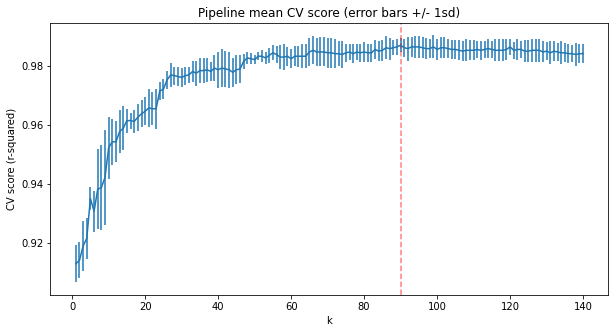

In [ ]:
plot_pipeline_mean_CV_score(cv_k, best_k, score_mean, score_std )

The above suggests a good value for k is ?. There was an initial rapid increase with k, followed by a slow decline. 

### 4.7.6 LightGBM Classifier<a id='4.7.6_LightGBM_Classifier'></a>

#### 4.7.6.1 Implimenting the model<a id='4.7.6.1_Implimenting_model'></a>

In [19]:
pipe6 = make_pipeline(
    StandardScaler(), 
    LGBMClassifier(n_jobs=-1, random_state=42)
)
pipe6.fit(X_train, y_train)
y_tr_pred = pipe6.predict(X_train)
y_te_pred = pipe6.predict(X_test)

In [23]:
pipe6.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'lgbmclassifier', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'lgbmclassifier__boosting_type', 'lgbmclassifier__class_weight', 'lgbmclassifier__colsample_bytree', 'lgbmclassifier__importance_type', 'lgbmclassifier__learning_rate', 'lgbmclassifier__max_depth', 'lgbmclassifier__min_child_samples', 'lgbmclassifier__min_child_weight', 'lgbmclassifier__min_split_gain', 'lgbmclassifier__n_estimators', 'lgbmclassifier__n_jobs', 'lgbmclassifier__num_leaves', 'lgbmclassifier__objective', 'lgbmclassifier__random_state', 'lgbmclassifier__reg_alpha', 'lgbmclassifier__reg_lambda', 'lgbmclassifier__silent', 'lgbmclassifier__subsample', 'lgbmclassifier__subsample_for_bin', 'lgbmclassifier__subsample_freq'])

#### 4.7.5.2  Assess performance<a id='4.7.5.2_Assess_performance'></a>

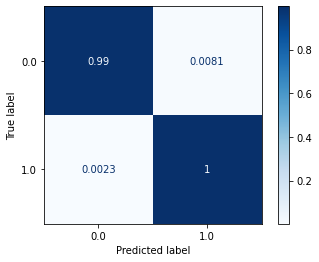

In [20]:
plot_confusion_matrix(estimator=pipe6, X=X_test, y_true=y_test, normalize='true', cmap='Blues')

In [21]:
print_performance_results(y_train, y_tr_pred,y_test, y_te_pred)    

 Accuracy score in train and test dataset:   1.0  ,  0.9953333333333333
 precision score in train and test dataset:  1.0  ,  0.9943566591422122
 Recall score in train and test dataset:     1.0  ,  0.9977349943374858
 F1 score in train and test dataset:         1.0  ,  0.9960429621254946


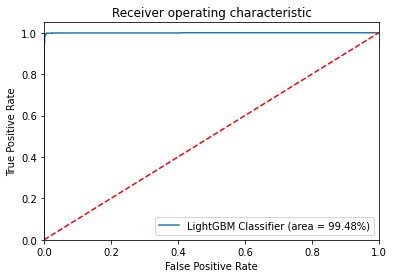

In [22]:
plot_ROC(pipe6, X_test, y_test,'LightGBM Classifier')

#### 4.7.5.3 Refining the model selecting a different number of features<a id='4.7.5.3_Refining_The_Model_selecting_a_different_number_of_features'></a>

In [24]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k, 'lgbmclassifier__max_depth': [2, 3, 5, 7, 10],
    'lgbmclassifier__n_estimators': [10, 100, 500]}
# param_grid = {
#     'pca__n_components': [5, 10, 15, 20, 25, 30],
#     'model__max_depth': [2, 3, 5, 7, 10],
#     'model__n_estimators': [10, 100, 500],
# }


pipe5_2 = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_regression, k=40),
    LGBMClassifier()
)
lr_grid_cv = GridSearchCV(pipe5_2, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]
best_k = lr_grid_cv.best_params_['selectkbest__k']
print('Best k: ',best_k)


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
Best k:  61


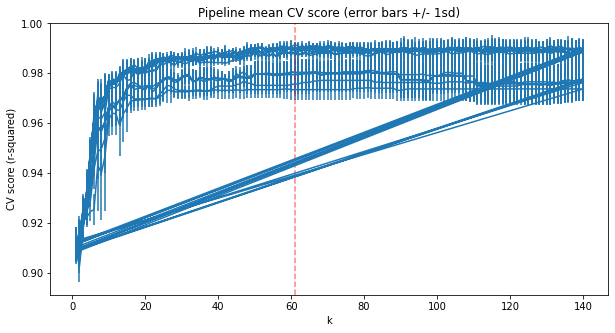

In [28]:
plot_pipeline_mean_CV_score(cv_k, best_k, score_mean, score_std )

The above suggests a good value for k is 61. 

## 4.8 Final Model Selection<a id='4.8_Final_Model_Selection'></a>

Time to select your final model to use for further business modeling! It would be good to revisit the above model selection; there is undoubtedly more that could be done to explore possible hyperparameters.
It would also be worthwhile to investigate removing the least useful features. Gathering or calculating, and storing, features adds business cost and dependencies, so if features genuinely are not needed they should be removed.
Building a simpler model with fewer features can also have the advantage of being easier to sell (and/or explain) to stakeholders.
Certainly there seem to be four strong features here and so a model using only those would probably work well.
However, you want to explore some different scenarios where other features vary so keep the fuller 
model for now. 
The business is waiting for this model and you have something that you have confidence in to be much better than guessing with the average price.



### 4.8.1 LightGBM<a id='4.8.1_LightGBM'></a>

The LightGBM model is selected as the model because of:
* the most TP rate= 1 
* the least FP rates = 0.0081
* the least features coresponded to the model = 61 

### 4.8.3 Conclusion<a id='4.8.3_Conclusion'></a>

## 4.9 Data quantity assessment<a id='4.9_Data_quantity_assessment'></a>

Finally, you need to advise the business whether it needs to undertake further data collection. Would more data be useful? We're often led to believe more data is always good, but gathering data invariably has a cost associated with it. Assess this trade off by seeing how performance varies with differing data set sizes. The `learning_curve` function does this conveniently.

In [ ]:
fractions = [.2, .25, .3, .35, .4, .45, .5, .6, .75, .8, 1.0]
train_size, train_scores, test_scores = learning_curve(pipe, X_train, y_train, train_sizes=fractions)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

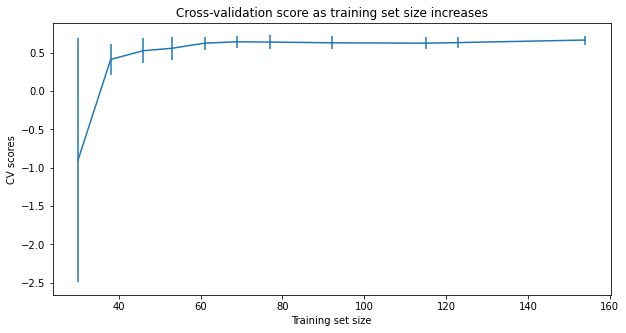

In [ ]:
plt.subplots(figsize=(10, 5))
plt.errorbar(train_size, test_scores_mean, yerr=test_scores_std)
plt.xlabel('Training set size')
plt.ylabel('CV scores')
plt.title('Cross-validation score as training set size increases');

This shows that you seem to have plenty of data. There's an initial rapid improvement in model scores as one would expect, but it's essentially levelled off by around a sample size of 40-50.

## 4.10 Save best model object from pipeline<a id='4.10_Save_best_model_object_from_pipeline'></a>

In [ ]:
best_model = rf_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [ ]:
# save the model

modelpath = '../models'
save_file(best_model, 'ECG_model.pkl', modelpath)

Directory ../models was created.
Writing file.  "../models\ski_resort_pricing_model.pkl"


Logistic Regression, Naïve Bayes, Stochastic Gradient Descent, K-Nearest Neighbors, Random Forest Classifiers, Support Vector Machine Classifiers,  XGBOOST Classifiers, LGBM Classifiers, Gradient boosting, and classical Neural Networks. 